<a href="https://colab.research.google.com/github/punkmic/Topic-Modeling-Reclame-Aqui/blob/master/Topic_Modeling_Reclame_Aqui_with_LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Topic Modeling with Latent Dirichlet Allocation (LDA) - Reclame Aqui**

LDA is an unsupervised learning algorithm which is able to learns about the structure of the data by analyzing the relationships between words and documents. LDA is based on the idea that each document in a collection can be represented as a mixture of a small number of topics, and that each topic is a distribution over the words in the vocabulary. The model estimates the probability of each word in a document given the topics present in that document, and it also estimates the probability of each topic given the words in the document.

Reference: BLEI, D. M. 2012 Probabilistic topic models. Communications of the ACM, 55(4): pp.77_84.


### **Load data from [Github](https://github.com/punkmic/Topic-Modeling-Reclame-Aqui.git)**

#### **Load dependecies**

In [29]:
%%capture
try:
  import pandas as pd # for data manipulation
  import os # for interacting with the operating system
  from sklearn.cluster import KMeans
  import matplotlib.ticker as ticker
  from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
  from sklearn.metrics import silhouette_score
  import matplotlib.pyplot as plt
  import pickle
  import numpy as np
  import itertools
  from matplotlib.lines import Line2D
  import seaborn as sns
  import csv
  from wordcloud import WordCloud
  import optuna # for hyperparameter optimization
  import pyLDAvis
  import pyLDAvis.gensim_models as gs
  from gensim.utils import simple_tokenize
  from gensim.models import LdaMulticore
  from gensim.utils import simple_preprocess
  from gensim import models
  from gensim.corpora import Dictionary
  from gensim.models.coherencemodel import CoherenceModel
  from gensim.models.phrases import Phrases, Phraser
except:
  !pip install gensim
  !pip install pyldavis
  !pip install optuna
  !pip install wordcloud
  from gensim import models
  from gensim.corpora import Dictionary
  from gensim.models.coherencemodel import CoherenceModel
  from gensim.models import LdaMulticore
  from gensim.utils import simple_preprocess
  import optuna # for hyperparameter optimization

In [3]:
WORK_DIR = '/content/Topic-Modeling-Reclame-Aqui'
DATASETS_DIR = '/content/Topic-Modeling-Reclame-Aqui/datasets'
LDA_RESULTS_DIR = '/content/Topic-Modeling-Reclame-Aqui/lda'

#### **Github**

In [5]:
! ssh-keygen -t rsa -b 4096
# Add github.com to our known hosts
! ssh-keyscan -t rsa github.com >> ~/.ssh/known_hosts
# Restrict the key permissions, or else SSH will complain.
! chmod go-rwx /root/.ssh/id_rsa

Generating public/private rsa key pair.
Enter file in which to save the key (/root/.ssh/id_rsa): 
Enter passphrase (empty for no passphrase): 
Enter same passphrase again: 
Your identification has been saved in /root/.ssh/id_rsa
Your public key has been saved in /root/.ssh/id_rsa.pub
The key fingerprint is:
SHA256:fpIa/kMNuoLr0QWDkWXDHILezmWBlkRbRXDpBrX3wr0 root@47c288555258
The key's randomart image is:
+---[RSA 4096]----+
| .=BB+==.        |
|. .O=+...        |
|. +.o +. .       |
| . . = o+ o      |
|  o o o.S= o     |
|   + .....o .    |
|  ... .o+ .E     |
|  .....o.o       |
| .o. .o...       |
+----[SHA256]-----+
# github.com:22 SSH-2.0-babeld-f1c576c9


In [6]:
! cat /root/.ssh/id_rsa.pub

ssh-rsa AAAAB3NzaC1yc2EAAAADAQABAAACAQDNw4dEK52ReEQ78ZTsbnVpUtYv3/mMYdhl0mu+JB4zIk8OkhD4Rl2Z+PPqoBzYIqDrgiKMnl/RynGTqmYKSSy6JVguBfjX0RO/WUSNfb8mIexZJadsE3E4zQTJGO4ZMOHSlqqwiHdDbVXMkgl+gPUeH56C690xPxEXrFBdrmllXPbczlWsRlJbZUR2CpWoTlUH72XwzJUieTH3kKy1F1ANmL+luUnw6NU2cMkChstDS8Z/2Sz3xOnB1a/7PmN9q8duE9WYlYY5d8+Ve99dYFK5S9bnmu3orxosNCvrblmGY2cbm0rL9dl+qFHHaQWtRVTVx8mpnyZcFhgbXZIJ/xRj13Rzw1Mq7vJGYnOERtZ+07GtpsXu6PC1ZdCICPzi8YZE/+BbjnO36oznnGiE7wSKXzv8e8Ydcmw0io16/Ae/nrXZHlanfdheb+n31fVvSqwSQm6JcCPJB7fWxDZ2od40cNuysiU5I+iW1P+lD4PlDjBxOk59/77vke4VUVo6NNPL5nN1bNRCuUsBzyjB29IGmz8e42AK+e56Q7tbOQwWIuleLu/8SHl8nl7jGkEOj5xcCeDR1K8PeAWxwFUGwUI/KN1WxVkVLd1vtmXkDQtpEA73NFG6yAjaaWT8fpAjazINDaMxQfI/cFT0f3iYwka/0BKeJKSzsviBFtW9JJMvTQ== root@47c288555258


In [7]:
!git config --global user.email "mattheus_ribeiro@oulook.com"
!git config --global user.name "punkmic"

In [8]:
!ssh -T git@github.com

Hi punkmic! You've successfully authenticated, but GitHub does not provide shell access.


In [9]:
!git clone git@github.com:punkmic/Topic-Modeling-Reclame-Aqui.git

Cloning into 'Topic-Modeling-Reclame-Aqui'...
remote: Enumerating objects: 16425, done.
remote: Counting objects: 100% (2244/2244), done.
remote: Compressing objects: 100% (1864/1864), done.
remote: Total 16425 (delta 366), reused 2199 (delta 345), pack-reused 14181
Receiving objects: 100% (16425/16425), 142.71 MiB | 18.48 MiB/s, done.
Resolving deltas: 100% (1514/1514), done.
Updating files: 100% (14841/14841), done.


In [ ]:
%cd /content/Topic-Modeling-Reclame-Aqui/

#### **Load dataset**

In [10]:
DATASET_VERSION = 'v1'

In [11]:
df = pd.read_csv(os.path.join(DATASETS_DIR, f'preprocessed_{DATASET_VERSION}.csv'))

In [18]:
df.head()

,title,documents,words,bigrams,noun_bigrams,trigrams,noun_trigrams,documents_nouns
0,pedir cancelado justificativa semana compro,pesquisando bastante novo comprar resolver agu...,"['pesquisando', 'bastante', 'novo', 'comprar',...","[(pesquisando, bastante), (bastante, novo), (n...","[(semana, desconto), (desconto, promoção), (pr...","[('pesquisando', 'bastante', 'novo'), ('bastan...","[(semana, desconto, promoção), (desconto, prom...",semana desconto promoção desconto compra custo...
1,pedir cancelar,sinceramente decepcionar entrar contato procon...,"['sinceramente', 'decepcionar', 'entrar', 'con...","[(sinceramente, decepcionar), (decepcionar, en...","[(procon, audiência), (audiência, conciliação)...","[('sinceramente', 'decepcionar', 'entrar'), ('...","[(procon, audiência, conciliação), (audiência,...",procon audiência conciliação solicitação produ...
2,cobrança indever,cancelei plano antes terminar período testir g...,"['cancelei', 'plano', 'antes', 'terminar', 'pe...","[(cancelei, plano), (plano, antes), (antes, te...","[(cancelei, período), (período, plataforma), (...","[('cancelei', 'plano', 'antes'), ('plano', 'an...","[(cancelei, período, plataforma), (período, pl...",cancelei período plataforma fatura gratuito ca...
3,pedir reincidente,olhar compra vir errar vir errar novamente fal...,"['olhar', 'compra', 'vir', 'errar', 'vir', 'er...","[(olhar, compra), (compra, vir), (vir, errar),...","[(compra, problema), (problema, desodorante)]","[('olhar', 'compra', 'vir'), ('compra', 'vir',...","[(compra, problema, desodorante)]",compra problema desodorante
4,assinaturar vender,inscrevi realizar venda cadastro plano individ...,"['inscrevi', 'realizar', 'venda', 'cadastro', ...","[(inscrevi, realizar), (realizar, venda), (ven...","[(venda, cadastro), (cadastro, venda), (venda,...","[('inscrevi', 'realizar', 'venda'), ('realizar...","[(venda, cadastro, venda), (cadastro, venda, s...",venda cadastro venda surpresa mensagem pagamen...


## **KMeans Model**

#### **K-Means elbow**

The elbow method is a type of method for checking the consistency of clusters created. It  finds the ideal number of clusters in data. Explained variance considers the percentage of variance explained and derives an ideal number of clusters. 

In [24]:
documents = df['documents_nouns']

In [25]:
if not os.path.exists(LDA_RESULTS_DIR):
    os.makedirs(LDA_RESULTS_DIR)

In [26]:
# convert text documents to bag of words representation
vectorizer = CountVectorizer()
x = vectorizer.fit_transform(documents)

In [30]:
%%time
def plot_elbow(n_clusters= 20):
  elbow_method = {}
  for k in range(1, n_clusters):
    kmeans_elbow = KMeans(n_clusters=k).fit(x)
    elbow_method[k] = kmeans_elbow.inertia_

  # plot elbow
  plt.figure(figsize=[8, 8])
  plt.plot(list(elbow_method.keys()), list(elbow_method.values()))
  plt.title('Elbow', fontsize=16)
  plt.xlabel('Número de grupos')
  plt.ylabel('Soma de quadrados dentro do cluster')

  # save plot
  plt.savefig(os.path.join(LDA_RESULTS_DIR, f'elbow_{n_clusters}_{DATASET_VERSION}.png'))

  # show the plot
  plt.show()

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 11.4 µs


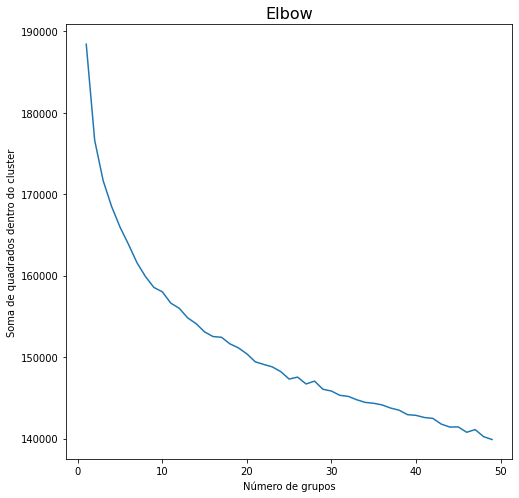

In [31]:
plot_elbow(50)

#### **Silhouette**

The silhouette coefficient, or silhouette score, tells how much the object is similar to  other clusters compared to its own cluster. The value varies from –1 to 1, where a high  value indicates that the cluster fits well with itself, and the cluster does not match the neighboring cluster.

In [204]:
clusters = []
scores = []
for n_cluster in range(2, 15):
  kmeans = KMeans(n_clusters=n_cluster).fit(x)
  label = kmeans.labels_
  sil_coeff = silhouette_score(x, label, metric='euclidean')
  print(f"Number of clusters={n_cluster}, Silhouette Coefficient is {sil_coeff}")
  clusters.append(n_cluster) 
  scores.append(sil_coeff)

Number of clusters=2, Silhouette Coefficient is 0.2319832193039109
Number of clusters=3, Silhouette Coefficient is 0.1880042896249773
Number of clusters=4, Silhouette Coefficient is 0.15936431903186152
Number of clusters=5, Silhouette Coefficient is 0.156349078683526
Number of clusters=6, Silhouette Coefficient is 0.12907710797941538
Number of clusters=7, Silhouette Coefficient is 0.12855052387333216
Number of clusters=8, Silhouette Coefficient is 0.009685796859280242
Number of clusters=9, Silhouette Coefficient is 0.011246831844951987
Number of clusters=10, Silhouette Coefficient is 0.023294133273837767
Number of clusters=11, Silhouette Coefficient is 0.037793913010897115
Number of clusters=12, Silhouette Coefficient is 0.012448452108736487
Number of clusters=13, Silhouette Coefficient is -0.002572245857416312
Number of clusters=14, Silhouette Coefficient is 0.006063231539932251


In [208]:
df_silh = pd.DataFrame({'cluster':clusters,'score': scores})
df_silh.to_csv(os.path.join(LDA_RESULTS_DIR, f'silhouette_scores_{DATASET_VERSION}.csv'), index=False)

#### **Clustering model**

In [34]:
# create a model with two clusters and train it
segments = KMeans(n_clusters=2)
segments.fit(x)

# get model labels
output = segments.labels_.tolist()
output_df = pd.DataFrame({'texts': documents, 'cluster': output})

output_df['cluster'] = segments.labels_.tolist()

cluster_1 = output_df[output_df.cluster == 1]
cluster_0 = output_df[output_df.cluster == 0]

**Wordcloud of cluster 1**

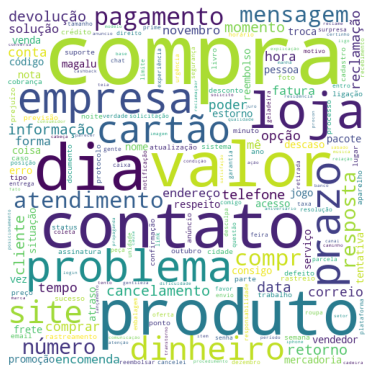

In [35]:
wordcloud = WordCloud(width = 500, height = 500,
                      collocations = False, 
                      colormap='viridis', 
                      background_color ='white', 
                      random_state=20).generate_from_text(' '.join(cluster_1['texts']))
plt.figure(figsize=(5,5), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0) 
plt.savefig(os.path.join(LDA_RESULTS_DIR, f'cluster_1_wordclooud_{DATASET_VERSION}.png'))
plt.show()

**Wordcloud of cluster 0**

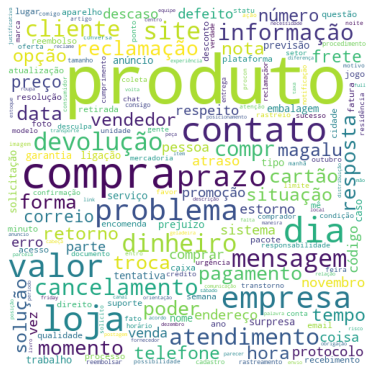

In [36]:
wordcloud = WordCloud(width = 500, height = 500,
                      collocations = False,
                      background_color ='white', 
                      colormap='viridis',
                      random_state=20).generate_from_text(' '.join(cluster_0['texts']))
plt.figure(figsize=(5,5), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0) 
plt.savefig(os.path.join(LDA_RESULTS_DIR, f'cluster_0_wordclooud_{DATASET_VERSION}.png'))
plt.show()

## **LDA models**

#### **Plot coherence**

Coherence score measures how semantically close the words in a topic are to each other. Higher coherence scores indicate that the words in a topic are more semantically similar, and therefore the topic is more interpretable and meaningful.

In [37]:
def plot_coherence(coherence_scores, n_topics, prefix):
  # create the plot
  plt.figure(figsize=[10, 8])

  # create a line plot
  ax = sns.lineplot(x=list(coherence_scores.keys()), y=list(coherence_scores.values()), color='#238C8C')

  # add labels to the axes
  plt.xlabel('Número de Tópicos')
  plt.ylabel('Coerência (score)')
  plt.title("Coerência por número de tópicos", fontsize=16)
  
  # set x-axis limits
  plt.xlim(2, n_topics)

  # customize x-ticks
  plt.xticks(range(2, n_topics, 2))

  # Add a vertical line to show the optimum number of topics
  position = list(coherence_scores.keys())[np.argmax(list(coherence_scores.values()))]
  plt.axvline(position,  color='#F26457', linestyle='--')  

  # Draw a custom legend
  legend_elements = [Line2D([0], [0], color='#238C8C', 
                          ls='-', label='Valor de coerência (c_v)'),
                   Line2D([0], [1], color='#F26457', 
                          ls='--', label='Número de tópicos ótimo')]

  ax.legend(handles=legend_elements, loc='upper right')

  # save plot
  plt.savefig(os.path.join(LDA_RESULTS_DIR, f'{prefix}_coherence_by_topics_{DATASET_VERSION}.png'))

  # show the plot
  plt.show()

In [38]:
NUMBER_OF_TOPICS = 24

#### **Unigram LDA**

In [39]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Tokenize the text data
tokens = [simple_preprocess(doc) for doc in documents]

# Create a dictionary from the tokens
dictionary = Dictionary(tokens)

# Filter out words that occur more than X% of the documents.
#dictionary.filter_extremes(no_above=0.90)

# Create a corpus from the tokens
corpus = [dictionary.doc2bow(token) for token in tokens]

# Create a dict to store the coherence scores
coherence_scores = {}

# Create LDA models for different number of topics
for num_topics in range(2, NUMBER_OF_TOPICS, 2):
    lda_model = LdaMulticore(corpus=corpus,
                             id2word=dictionary, 
                             num_topics=num_topics,
                             random_state=100,
                             passes=2,
                             iterations=100)
    
    coherence_model = CoherenceModel(model=lda_model, 
                                     texts=tokens,
                                     corpus=corpus,
                                     dictionary=dictionary, 
                                     coherence='c_v')
    
    coherence_scores[num_topics] = coherence_model.get_coherence()

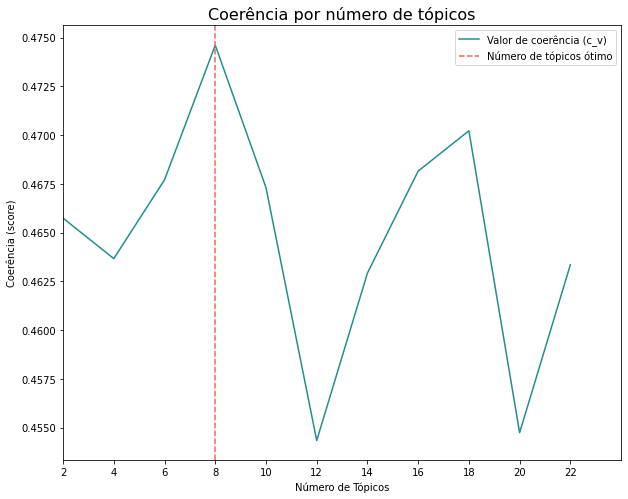

In [40]:
plot_coherence(coherence_scores, NUMBER_OF_TOPICS, 'unigrams')

#### **Bigrams LDA**

In [41]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Tokenize the text data
tokens = [simple_preprocess(doc) for doc in documents]

# create bigrams
bigram = Phrases(tokens, min_count=1, threshold=1)
bigram_phraser = Phraser(bigram)
texts = [bigram_phraser[doc] for doc in tokens]

# create a dictionary from the bigrams
dictionary = Dictionary(texts)

# Filter out words that occur more than X% of the documents.
#dictionary.filter_extremes(no_above=0.90)

# create a corpus from the bigrams
corpus = [dictionary.doc2bow(text) for text in texts]

# create a dict to store the coherence scores
coherence_scores = {}

# create LDA models for different number of topics
for num_topics in range(2, NUMBER_OF_TOPICS, 2):
    lda_model = LdaMulticore(corpus=corpus,
                             id2word=dictionary, 
                             num_topics=num_topics,
                             random_state=100,
                             passes=2,
                             iterations=100)
    
    coherence_model = CoherenceModel(model=lda_model, 
                                     texts=texts,
                                     corpus=corpus,
                                     dictionary=dictionary, 
                                     coherence='c_v')
    
    coherence_scores[num_topics] = coherence_model.get_coherence()

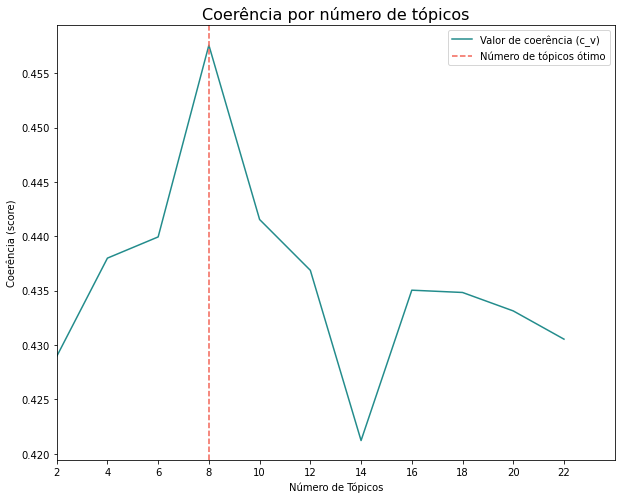

In [42]:
plot_coherence(coherence_scores, NUMBER_OF_TOPICS, 'bigrams')

#### **Trigrams LDA**

In [43]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

# tokenize the text data
tokens = [simple_preprocess(doc) for doc in documents]

# Create trigrams
trigram = Phrases(tokens, min_count=1, threshold=1)
trigram_phraser = Phraser(trigram)
texts = [trigram_phraser[bigram_phraser[token]] for token in tokens]

# create a dictionary from the trigrams
dictionary = Dictionary(texts)

# Filter out words that occur more than X% of the documents.
#dictionary.filter_extremes(no_above=0.90)

# create a corpus from the trigrams
corpus = [dictionary.doc2bow(text) for text in texts]

# create a dict to store the coherence scores
coherence_scores = {}

# create LDA models for different number of topics
for num_topics in range(2, NUMBER_OF_TOPICS, 2):
    lda_model = LdaMulticore(corpus=corpus,
                             id2word=dictionary, 
                             num_topics=num_topics,
                             random_state=100,
                             passes=2,
                             iterations=100)
    
    coherence_model = CoherenceModel(model=lda_model, 
                                     texts=texts,
                                     corpus=corpus,
                                     dictionary=dictionary, 
                                     coherence='c_v')
    
    coherence_scores[num_topics] = coherence_model.get_coherence()

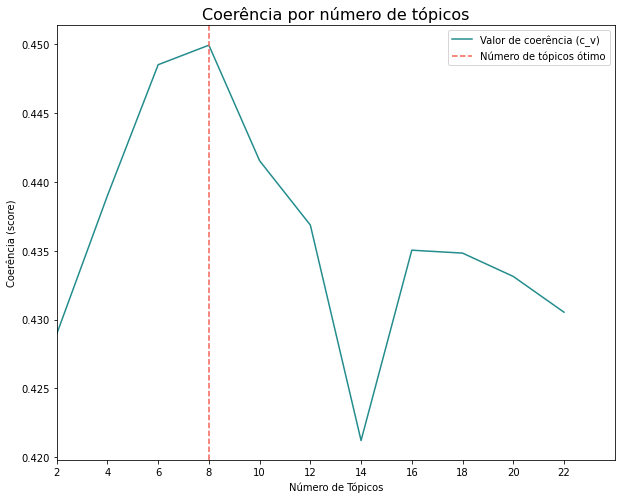

In [44]:
plot_coherence(coherence_scores, NUMBER_OF_TOPICS, 'trigrams')

#### **Hyperparameter tuning**

In [45]:
# set the minimum and maximum number of topics based on coherence score plots
MIN_TOPICS = 2
MAX_TOPICS = 12

# delete csv if it exists
path = os.path.join(LDA_RESULTS_DIR, f'coherence_scores_{DATASET_VERSION}.csv')
if os.path.exists(path):
  os.remove(path)

def optimizer(trial):
   alpha = trial.suggest_float('lda_alpha', 0.01, 1.0)
   eta = trial.suggest_float('lda__eta', 0.01, 1.0)
   nr_topics = trial.suggest_int('lda__nr_topics', MIN_TOPICS, MAX_TOPICS)
   min_count = trial.suggest_int('bigram__min_count', 2, 20)
   filter = trial.suggest_float('dictionary__filter_extremes', 0.70, 0.95)

   # tokenize the text data
   tokens = [simple_preprocess(doc) for doc in documents]

   # add bigrams to docs (only ones that appear x times or more).
   bigram = Phrases(tokens, min_count=min_count, threshold=1)
   bigram_phraser = Phraser(bigram)
   texts = [bigram_phraser[token] for token in tokens] 
  
   # create a corpus from a list of texts
   dictionary = Dictionary(texts)

   # Filter out words that occur more than X% of the documents.
   dictionary.filter_extremes(no_above=filter)

   # convert documents to bag of words
   corpus = [dictionary.doc2bow(text) for text in texts]

   # create a new LDA model
   lda_model = LdaMulticore(corpus=corpus,
                           id2word=dictionary,
                           num_topics=nr_topics,
                           random_state=100,
                           passes=2,
                           iterations=100,
                           alpha=alpha,
                           eta=eta)
  
   # compute coherence score
   score = CoherenceModel(lda_model, texts=texts, corpus=corpus, dictionary=dictionary).get_coherence()

   # save scores
   if not os.path.exists(LDA_RESULTS_DIR):
     os.makedirs(LDA_RESULTS_DIR)

   with open(path, 'a', newline='') as f:
     fieldnames = ['score', 'tópicos', 'alpha', 'eta', 'min_count', 'filter_extremes']
     writer = csv.DictWriter(f, fieldnames=fieldnames)
     data = [{'score': score,
              'tópicos': nr_topics, 
              'alpha': alpha,
              'eta': eta,
              'min_count': min_count,
              'filter_extremes':filter}]
     writer.writerows(data)
   return  score

In [46]:
%%time
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
NUMBER_OF_MODELS = 40
# create a new study
study = optuna.create_study(study_name=f'LDA_{DATASET_VERSION}', direction='maximize')

# run the optmize function 
study.optimize(optimizer, n_trials=NUMBER_OF_MODELS, show_progress_bar=True)

# best
print('Best value %s', study.best_value)
print('Best params: %s', study.best_params)

/usr/local/lib/python3.8/dist-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2023-01-21 02:14:49,633] Trial 0 finished with value: 0.4508379217680583 and parameters: {'lda_alpha': 0.24138363232606594, 'lda__eta': 0.06448307067896261, 'lda__nr_topics': 11, 'bigram__min_count': 6, 'dictionary__filter_extremes': 0.7063376935018011}. Best is trial 0 with value: 0.4508379217680583.
[I 2023-01-21 02:15:09,200] Trial 1 finished with value: 0.46522222217120257 and parameters: {'lda_alpha': 0.6171265288263443, 'lda__eta': 0.341189427222335, 'lda__nr_topics': 10, 'bigram__min_count': 16, 'dictionary__filter_extremes': 0.9235354178945465}. Best is trial 1 with value: 0.46522222217120257.
[I 2023-01-21 02:15:28,761] Trial 2 finished with value: 0.4498581966393351 and parameters: {'lda_alpha': 0.14484709543263166, 'lda__eta': 0.5998486862759659, 'lda__nr_topics': 5, 'bigram__min_count': 14, 'dictionary__filter_extremes': 0.778650823971168}. Best is trial 1 with value: 0.46522222217120257.
[I 2023-01-21 02:15:46,535] Trial 3 finished with value: 0.4231828271017959 and par

In [47]:
NUMBER_OF_TOPICS = 8

#### **Visualization of Topics**

In [48]:
def save_lda_vis(prefix, lda, nr_topics, corpus, dictionary):
  path = os.path.join(LDA_RESULTS_DIR, f'ldavis_{str(nr_topics)}_{DATASET_VERSION}')

  vis = gs.prepare(lda, corpus, dictionary)
 
  with open(path, 'wb') as f:
        pickle.dump(vis, f)

  with open(path, 'rb') as f:
    vis = pickle.load(f)
  
  pyLDAvis.save_html(vis, os.path.join(LDA_RESULTS_DIR, f'{prefix}_ldavis_{str(nr_topics)}_{DATASET_VERSION}.html'))

In [ ]:
def get_topics(lda, nr_topics):
  x=lda.show_topics(num_topics=nr_topics, num_words=10, formatted=False)
  topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]
  topics = []
  words = []
  for t, w in topics_words:
    topics.append(t)
    words.append(w)
  return pd.DataFrame({'Tópicos': topics, 'Words': words})

In [80]:
def get_words_by_topic_id(lda, topic_id, topn=20):
  return [dictionary[word_id] for word_id, prob in lda.get_topic_terms(topic_id, topn=topn)]

In [182]:
def get_words_n_score_by_topic_id(lda, topics, topn=10):
  ls = []
  for id in topics:
    ls.append([(dictionary[word_id], prob) for word_id, prob in lda.get_topic_terms(id, topn=topn)])
  return ls

#### **Topics of the optimized model**

In [57]:
filename = os.path.join(LDA_RESULTS_DIR, f'coherence_scores_{DATASET_VERSION}.csv')
scores = pd.read_csv(filename, header=None)
scores.columns = ['score', 'topic', 'alpha', 'eta', 'min_count', 'filter_extremes']
max_value = scores['score'].max()
row = scores.loc[scores['score'] == max_value]
alpha = row['alpha'].astype(float).values[0]
eta = row['eta'].astype(float).values[0]
nr_topics = row['topic'].astype(int).values[0]
min_count = row['min_count'].astype(int).values[0]

# tokenize the text data
tokens = [simple_preprocess(doc) for doc in documents]

# add bigrams to docs (only ones that appear x times or more).
bigram = Phrases(tokens, min_count=min_count, threshold=1)
bigram_phraser = Phraser(bigram)
texts = [bigram_phraser[token] for token in tokens] 
  
# create a corpus from a list of texts
dictionary = Dictionary(texts)

# Filter out words that occur more than X% of the documents.
dictionary.filter_extremes(no_above=0.95)

# convert documents to bag of words
corpus = [dictionary.doc2bow(text) for text in texts]

# create a new LDA model
lda_model = LdaMulticore(corpus=corpus,
                           id2word=dictionary,
                           num_topics=nr_topics,
                           random_state=100,
                           passes=2,
                           iterations=100,
                           alpha=alpha,
                           eta=eta)

# save topics terms
topics_terms = get_topics(lda_model, NUMBER_OF_TOPICS)
topics_terms.to_csv(os.path.join(LDA_RESULTS_DIR, f'topics_terms_optimized_model_{DATASET_VERSION}.csv'), index=False)
topics_terms.head(NUMBER_OF_TOPICS)



In [58]:
print(CoherenceModel(lda_model, texts=texts, corpus=corpus, dictionary=dictionary).get_coherence())

0.4911185086368712


In [59]:
save_lda_vis('optimized', lda_model, nr_topics, corpus, dictionary)

vis = gs.prepare(lda_model, corpus, dictionary)
gs.pyLDAvis.display(vis)

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


#### **Plot topics terms**

In [191]:
def plot_topics_terms(lda, topics, filename):
  data = get_words_n_score_by_topic_id(lda, topics, topn=10)

  fig, axs = plt.subplots(1, len(topics), figsize=(24, 5), tight_layout=True)

  for i, ax in enumerate(axs):
      terms = [d[0] for d in data[i]]
      scores = [d[1] for d in data[i]]
      sns.barplot(x=scores, y=terms, orient="h", ax=ax)
      ax.set_title("Tópico {}".format(i+1), fontsize = 20)
      ax.tick_params(axis='x', labelsize=16)
      ax.tick_params(axis='y', labelsize=16)

  plt.savefig(os.path.join(LDA_RESULTS_DIR, filename))
  plt.show()

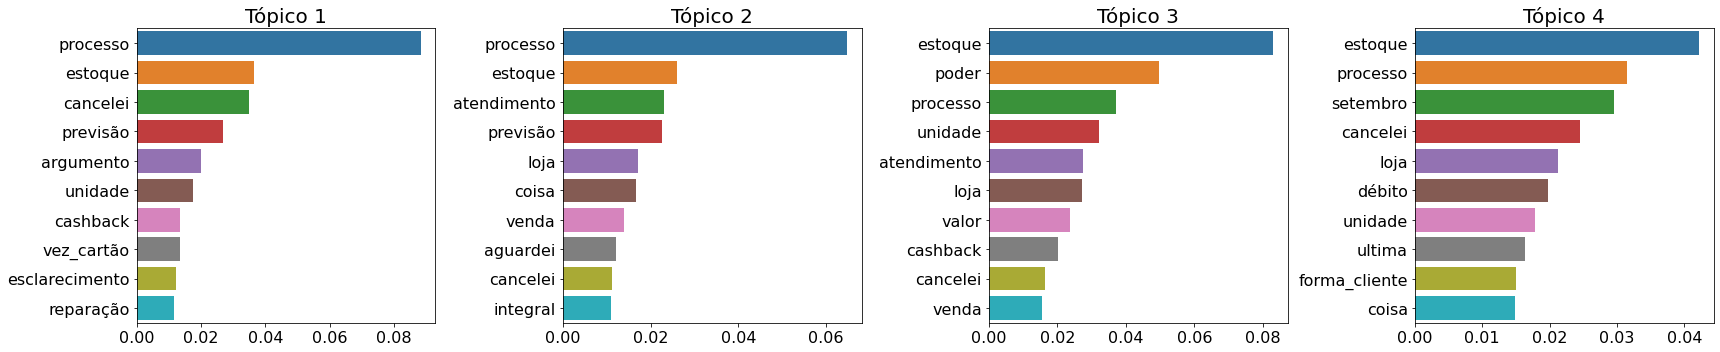

In [192]:
plot_topics_terms(lda_model, [1,3,4,6], 'optimized_model_topics_terms_plot.png')

#### **Wordclouds of optimized model**

In [ ]:
for t in range(lda_model.num_topics):
  wordcloud = WordCloud(width = 500, height = 500,
                      collocations = False,
                      background_color ='white', 
                      colormap='viridis',
                      random_state=20).generate_from_text(' '.join(get_words_by_topic_id(lda_model, t)))
  plt.figure(figsize=(5,5), facecolor=None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0) 
  dir = os.path.join(LDA_RESULTS_DIR, 'optimized_model_wordcloud')
  if not os.path.exists(dir):
    os.makedirs(dir)
  plt.savefig(os.path.join(LDA_RESULTS_DIR, 'optimized_model_wordcloud', f'optimization_wordcloud_topic_{str(t)}_{DATASET_VERSION}.png'))

#### **Cluster 0 topics visualization**

In [66]:
tokens = [simple_preprocess(doc) for doc in cluster_0.texts]

# add bigrams to docs (only ones that appear x times or more).
bigram = Phrases(tokens, min_count=2, threshold=1)
bigram_phraser = Phraser(bigram)
texts = [bigram_phraser[doc] for doc in tokens] 

# create a dictionary of bigrams
dictionary = Dictionary(texts)

# Filter out words that occur more than X% of the documents.
dictionary.filter_extremes(no_above=0.90)

corpus = [dictionary.doc2bow(text) for text in texts]

# create a new LDA model
lda_model_cluster_0 = LdaMulticore(corpus=corpus,
                           id2word=dictionary,
                           num_topics=NUMBER_OF_TOPICS,
                           random_state=100,
                           passes=10,
                           iterations=100)

save_lda_vis('cluster_0', lda_model_cluster_0, NUMBER_OF_TOPICS, corpus, dictionary)

# save topic terms
topics_terms = get_topics(lda_model_cluster_0, NUMBER_OF_TOPICS)
topics_terms.to_csv(os.path.join(LDA_RESULTS_DIR, f'topics_terms_cluster_0_{DATASET_VERSION}.csv'), index=False)
topics_terms.head(NUMBER_OF_TOPICS)

vis = gs.prepare(lda_model_cluster_0, corpus, dictionary)
gs.pyLDAvis.display(vis)

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


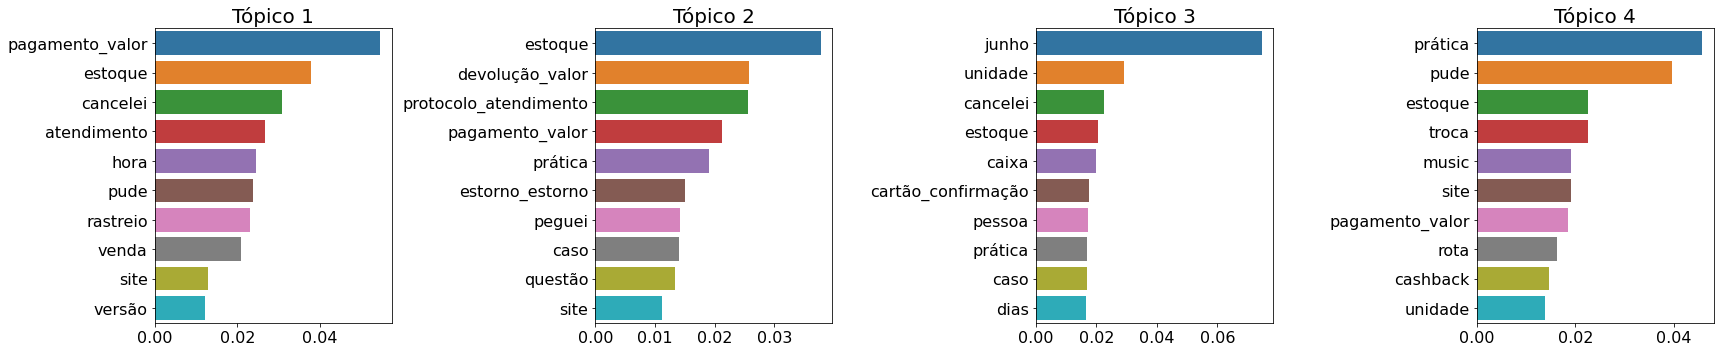

In [193]:
plot_topics_terms(lda_model_cluster_0, [1, 2, 3, 4], 'cluster_0_topics_terms_plot.png')

#### **Cluster 1 topics visualization**

In [67]:
tokens = [simple_preprocess(doc) for doc in cluster_1.texts]

# add bigrams to docs (only ones that appear x times or more).
bigram = Phrases(tokens, min_count=2, threshold=1)
bigram_phraser = Phraser(bigram)
texts = [bigram_phraser[doc] for doc in tokens] 

dictionary = Dictionary(texts)

# Filter out words that occur more than X% of the documents.
dictionary.filter_extremes(no_above=0.95)

corpus = [dictionary.doc2bow(text) for text in texts]

# create a new LDA model
lda_model_cluster_1 = LdaMulticore(corpus=corpus,
                           id2word=dictionary,
                           num_topics=NUMBER_OF_TOPICS,
                           random_state=100,
                           passes=10,
                           iterations=100)

save_lda_vis('cluster_1', lda_model_cluster_1, NUMBER_OF_TOPICS, corpus, dictionary)

# save topic terms
topics_terms = get_topics(lda_model_cluster_1, NUMBER_OF_TOPICS)
topics_terms.to_csv(os.path.join(LDA_RESULTS_DIR, f'topics_terms_cluster_1_{DATASET_VERSION}.csv'), index=False)
topics_terms.head(NUMBER_OF_TOPICS)

vis = gs.prepare(lda_model_cluster_1, corpus, dictionary)
gs.pyLDAvis.display(vis)

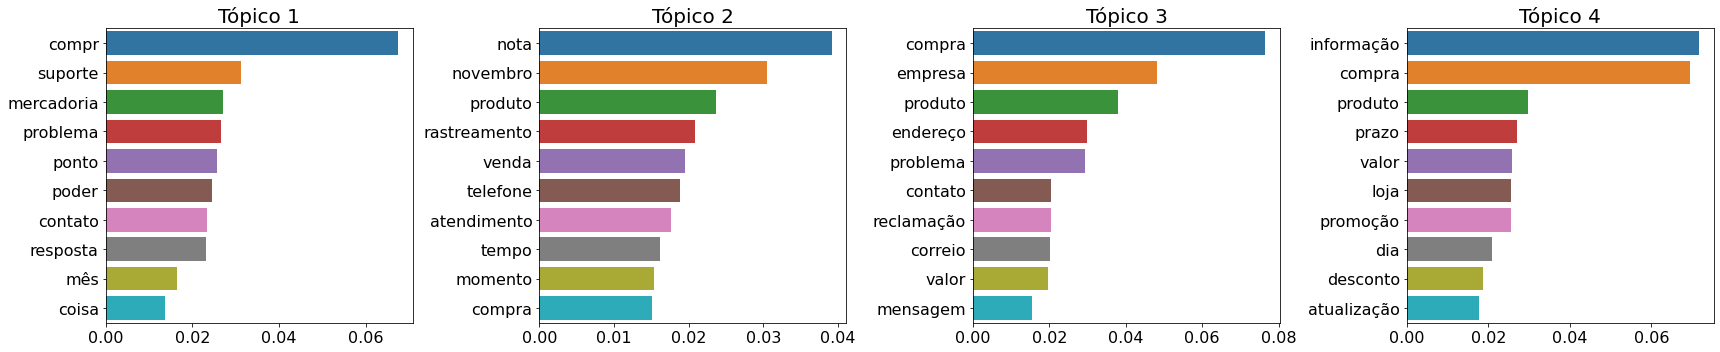

In [194]:
plot_topics_terms(lda_model_cluster_1, [1, 2, 3, 4], 'cluster_1_topics_terms_plot.png')

In [214]:
!rm -rf /root/.ssh/